<a href="https://colab.research.google.com/github/InbumS/DreamscomeTrue/blob/main/Alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ImageNet Classification with Deep Convolutional Neural Networks

[ImageNet ILVRC-2010]

Alex Krizhevsky가 만든 CNN기반의 모델

ImageNet Large Scale Visual Recognition Challenge 2012 우승 모델

높은 depth로 인한 high performance but 높은 자원율 필요

Features
 
 * sigmoid 나 tahh가 아닌 non-saturing activation인 ReLU의 사용

 * 기존 CV업계에서 사용했던 shallow learning에서 벗어난 end to end 형식의 학습방법
 


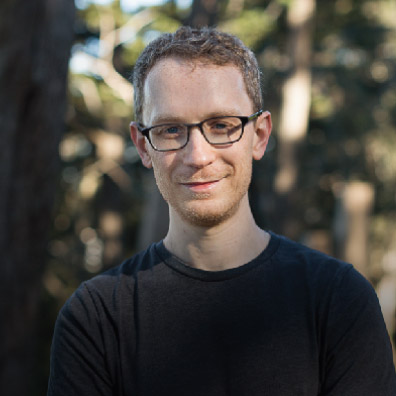

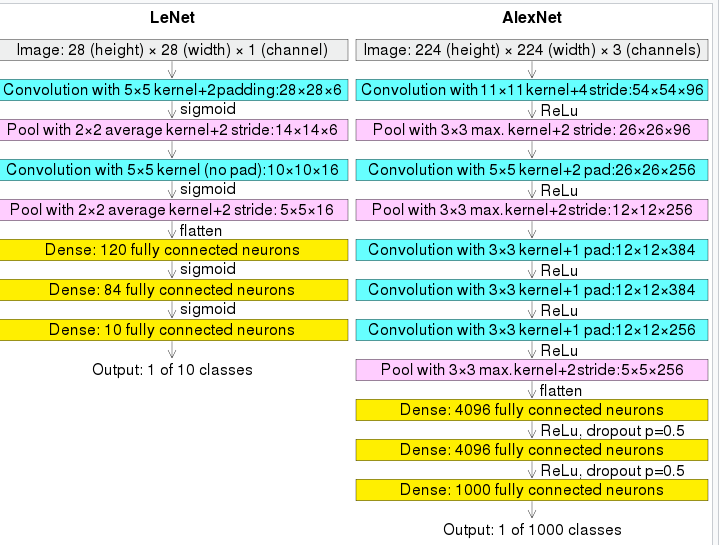

1. Activation function ==> 6번의 epochs로 ReLU는 25%의 Error

2. Local Response Normalization => input에 대한 saturing(극값이 어떠한 지점으로 수렴)을 막기 위한 normalization 필요는 없지만 scheme가 genalization한다.

3.Overlapping Pooling
같은 filter의 뉴런들을 summarize하여 출력
max-overlapping pooling

## overall architecture

렐루의 비선형성은 모든 convolutional layer와 fully-connected layer의 아웃풋에 적용

alexnet은 5개의 convolution layer와 3개의 full-connected layer로 구성

2,4,5번째 컨볼루션 레이어들은 전 단계의 같은 채널의 피쳐들과만 연결되어 있고, 세 번째 컨볼루션 레이어는 전 단계의 두 채널의 피쳐들과 모두 연결되어 있음

1 layer (convolution)

input feature : 244 x 244 x 3 (입력:rgb 컬러이미지)

kernel : 11 x 11 x 3

2 layer (convolution)

input feature : 55 x 55 x 96

kernel : 5 x 5 x 96

3 layer (convolution)

input feature : 27 x 27 x 256

kernel : 3 x 3 x 256

4 layer (convolution)

input feature : 13 x 13 x 384

kernel : 3 x 3 x 384

5 layer (convolution)

input feature : 13 x 13 x 384

kernel : 3 x 3 x 384

6 layer (fully-connected)

network : 4096

7 layer (fully-connected)

network : 4096

8 layer (fully-connected)

network : 1000

총 6000만개의 파라미터의 훈련

## Reducing Overfitting
1. data argumantation(데이터 증폭)
좌우반전, random crop(이미지 자르기랄까?..), PCA를 통한 rgb조절

2. dropout

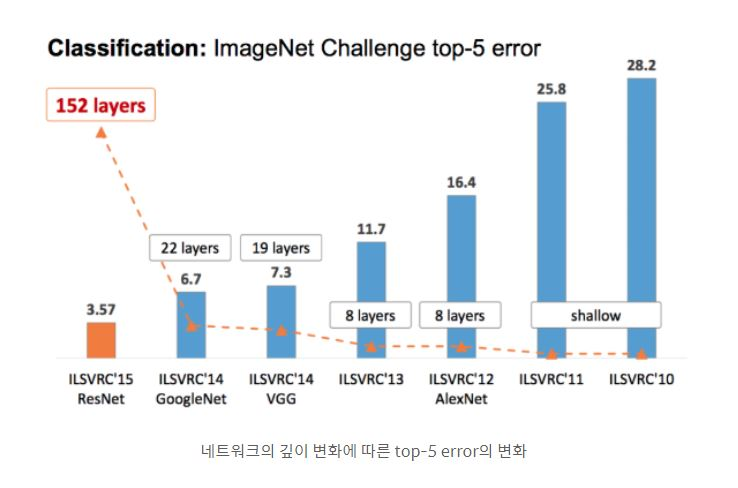


https://www.kaggle.com/code/sanjaybalamurugan/alexnet-for-cifar-10-dataset/notebook

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os

import skimage.transform
from skimage.util import img_as_ubyte
from tensorflow import keras
from keras.utils import np_utils

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras import optimizers
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,Conv2D, MaxPooling2D,BatchNormalization,LayerNormalization

# keras라이브러리를 사용,,

In [2]:
#cifar10 --> 32x32픽셀의 60000개 컬러이미지가 포함되어있으며, 각 이미지는 10개의 클래스로 라벨링된 데이터 셋

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print("Size of the train images", x_train.shape)
print("Size of the test images", x_test.shape)

170508288/170498071 [==============================] - 3s 0us/step
Size of the train images (50000, 32, 32, 3)
Size of the test images (10000, 32, 32, 3)


In [3]:
# test, train, validation data 분리
x_test, y_test = x_test[:5000], y_test[:5000]
x_val, y_val = x_train[:5000], y_train[:5000]
x_train, y_train = x_train[10000:], y_train[10000:]

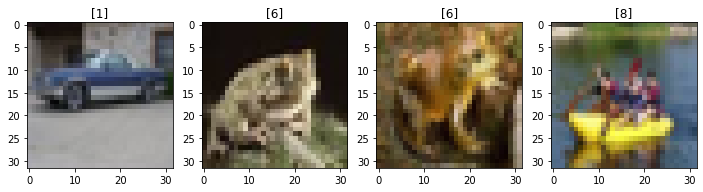

In [4]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

f = plt.figure(figsize=(12, 12)) #12, 12픽셀 사이즈로 설정

n = 4
for i in range(n):
    f.add_subplot(1, 4, i+1)
    plt.imshow(x_train[i])
    plt.title(str(y_train[i]) )


In [5]:
# Function to resize the images of the data into 227x227 

def convert(images):
    tmp = []
    for image in images:
        image = skimage.transform.resize(image,(227,227),mode='constant') ##
        tmp.append(image)
    return np.array(tmp)

In [ ]:
x_trainR = convert(x_train)
x_valR = convert(x_val)
x_test =convert(x_test)

In [6]:
# printing the size of all the transformed data

print("Training data size: ", x_train.shape)
print("Validation data size: ", x_val.shape)
print("Test data size: ", x_test.shape)
print("Training data Labels", y_train.shape)
print("Validation data Labels", y_val.shape)

Training data size:  (40000, 32, 32, 3)
Validation data size:  (5000, 32, 32, 3)
Test data size:  (5000, 32, 32, 3)
Training data Labels (40000, 1)
Validation data Labels (5000, 1)


In [7]:
#one hot encoding by 10 for Y Value
num_classes=10
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
y_val = np_utils.to_categorical(y_val, num_classes)

print("Train Labels size : ", y_train.shape)
print("Validation data Labels size: ", y_val.shape)
print("Test Data Labels size: ", y_test.shape)

Train Labels size :  (40000, 10)
Validation data Labels size:  (5000, 10)
Test Data Labels size:  (5000, 10)


In [9]:
# Shuffling the train and validation data
from sklearn.utils import shuffle

x_val, y_val  = shuffle(x_val, y_val)
x_train, y_train = shuffle(x_train, y_train)

# AlexNet MODEL


In [15]:
in_size = (227,227)

model= keras.models.Sequential([
    
    keras.layers.experimental.preprocessing.Resizing(in_size[0], in_size[1], interpolation="bilinear",input_shape=x_train.shape[1:]),

     # 1st-Layer 96개의 11 x 11 x 3 의 커널
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=image_size),
    keras.layers.BatchNormalization(),    # not local Response Normalization
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)), #Overmaxpooling => pool size > stride 크기
    
    # 2nd-Layer
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    # 3rd-Layer
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    # FC layer 
    keras.layers.Flatten(),  # 6 x 6 x 256 = 9216 개의 1차원 벡터
    
    # DNN
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    
    # Output
    keras.layers.Dense(10, activation='softmax')
])

# Compiling the Model
model.compile(optimizer ='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

# Training the model
history = model.fit(x_train, y_train, batch_size= 128, epochs=15,validation_data = (x_val, y_val))



NameError: ignored

In [ ]:
# Plotting the accuracy and loss 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.plot(epoch_range, acc, label='Training accuracy')
plt.plot(epoch_range, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epoch_range, loss, label='Training loss')
plt.plot(epoch_range, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Printing the Accuracy and the Loss for the Test data

loss,accuracy = model.evaluate(x_test,y_test)
print("Accuracy for test data : ",accuracy)
print("Loss for test data : ",loss)

In [ ]:
# For the Confusion Matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import multilabel_confusion_matrix

rounded_labels = np.argmax(y_test, axis=1)

preds = model.predict(x_test, batch_size = 64, verbose = 1)
preds = np.argmax(preds, axis=1) # to get the indices of max value in each row
cr = confusion_matrix(rounded_labels, preds)

In [ ]:
print(classification_report(rounded_labels, preds))

# Visualizing the Confusion Matrix

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cr, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cr.shape[0]):
    for j in range(cr.shape[1]):
        ax.text(x=j, y=i,s=cr[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)    
plt.title('Confusion Matrix', fontsize=18)
plt.show()